## Exploring Economic data with the FRED API 
By: Jeff W

### Intro
In this project, we dive into a popular repository of economic data provided by the Federal Reserve. The 'FRED' API can be used analyze and visualize key economic indicators. We will use Pandas and Numpy to help with data cleaning and processing, also using Plotly for data visualization. 

In [81]:
!pip install fredapi
!pip install plotly

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

plt.style.use('fivethirtyeight')
pd.options.display.max_columns = 500
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

#api info needed
#Please see (https://fred.stlouisfed.org/docs/api/api_key.html)

#### Here we see the S&P 500 plotted from 2015 to 2024.

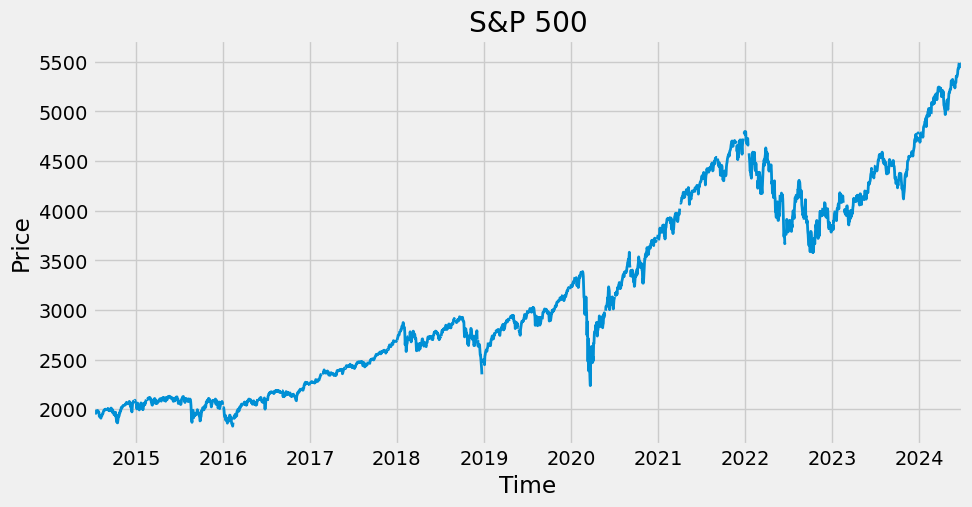

In [84]:
sp500 = fred.get_series(series_id='SP500')
#sp500.plot(figsize=(10, 5), title='S&P 500', lw=2)
#plt.show()

# Plot the S&P 500 data
sp500.plot(figsize=(10, 5), title='S&P 500', lw=2)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('S&P 500')
plt.show()

#### Pulling and Joining Data Series

In [92]:
unemp_df = fred.search('unemployment rate state', filter=('frequency','Monthly'))
#Search for unemp data by states
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
# Filter the search results to include only seasonally adjusted data in percent

unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate')]
#Filter the results further

In [93]:
all_results = []

for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    time.sleep(0.1) # Don't request to fast and get blocked
uemp_results = pd.concat(all_results, axis=1)

#Gathering unemp rates for each state and combining it into a single dataframe.

In [96]:
cols_to_drop = []
for i in uemp_results:
    if len(i) > 4:
        cols_to_drop.append(i)
uemp_results = uemp_results.drop(columns = cols_to_drop, axis=1)

In [98]:
uemp_states = uemp_results.copy()  #.drop('UNRATE', axis=1)
uemp_states = uemp_states.dropna()
id_to_state = unemp_df['title'].str.replace('Unemployment Rate in ','').to_dict()
uemp_states.columns = [id_to_state[c] for c in uemp_states.columns]

In [123]:
import pandas as pd
import plotly.express as px

# Making the df long format
uemp_states_long = uemp_states.reset_index().melt(id_vars='index', var_name='State', value_name='Unemployment Rate')
uemp_states_long = uemp_states_long.rename(columns={'index': 'Year'})

# Plotting the chart
fig = px.line(uemp_states_long, x='Year',
              y='Unemployment Rate',
              color='State',
              title='States Unemployment Rate')
fig.update_layout(legend_title_text='States')
fig.show()
#User can zoom into plot, by clicking and selecting what area to explore.

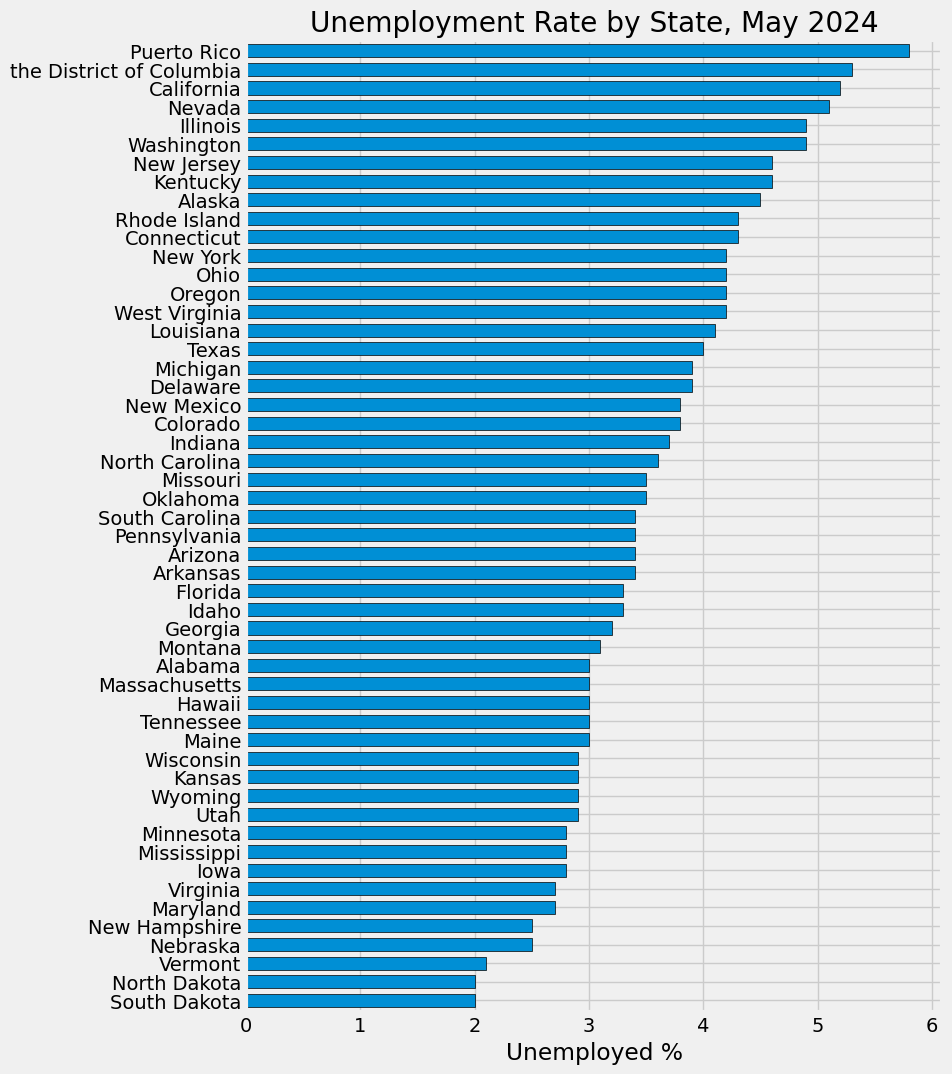

In [124]:
#This chart shows the unemployment rate by state for May of 2024.
ax = uemp_states.loc[uemp_states.index == '2024-05-01'].T \
    .sort_values('2024-05-01') \
    .plot(kind='barh', figsize=(8, 12), width=0.7, edgecolor='black',
          title='Unemployment Rate by State, May 2024')
ax.legend().remove()
ax.set_xlabel('Unemployed %')
plt.show()

### Gather data for participation rate and combine unemployment rates

In [129]:
part_df = fred.search('participation rate state', filter=('frequency','Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')

In [130]:
part_id_to_state = part_df['title'].str.replace('Labor Force Participation Rate for ','').to_dict()

all_results = []

for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    time.sleep(0.1)
part_states = pd.concat(all_results, axis=1)
part_states.columns = [part_id_to_state[c] for c in part_states.columns]

In [131]:
# To fix DC
uemp_states = uemp_states.rename(columns={'the District of Columbia':'District Of Columbia'})

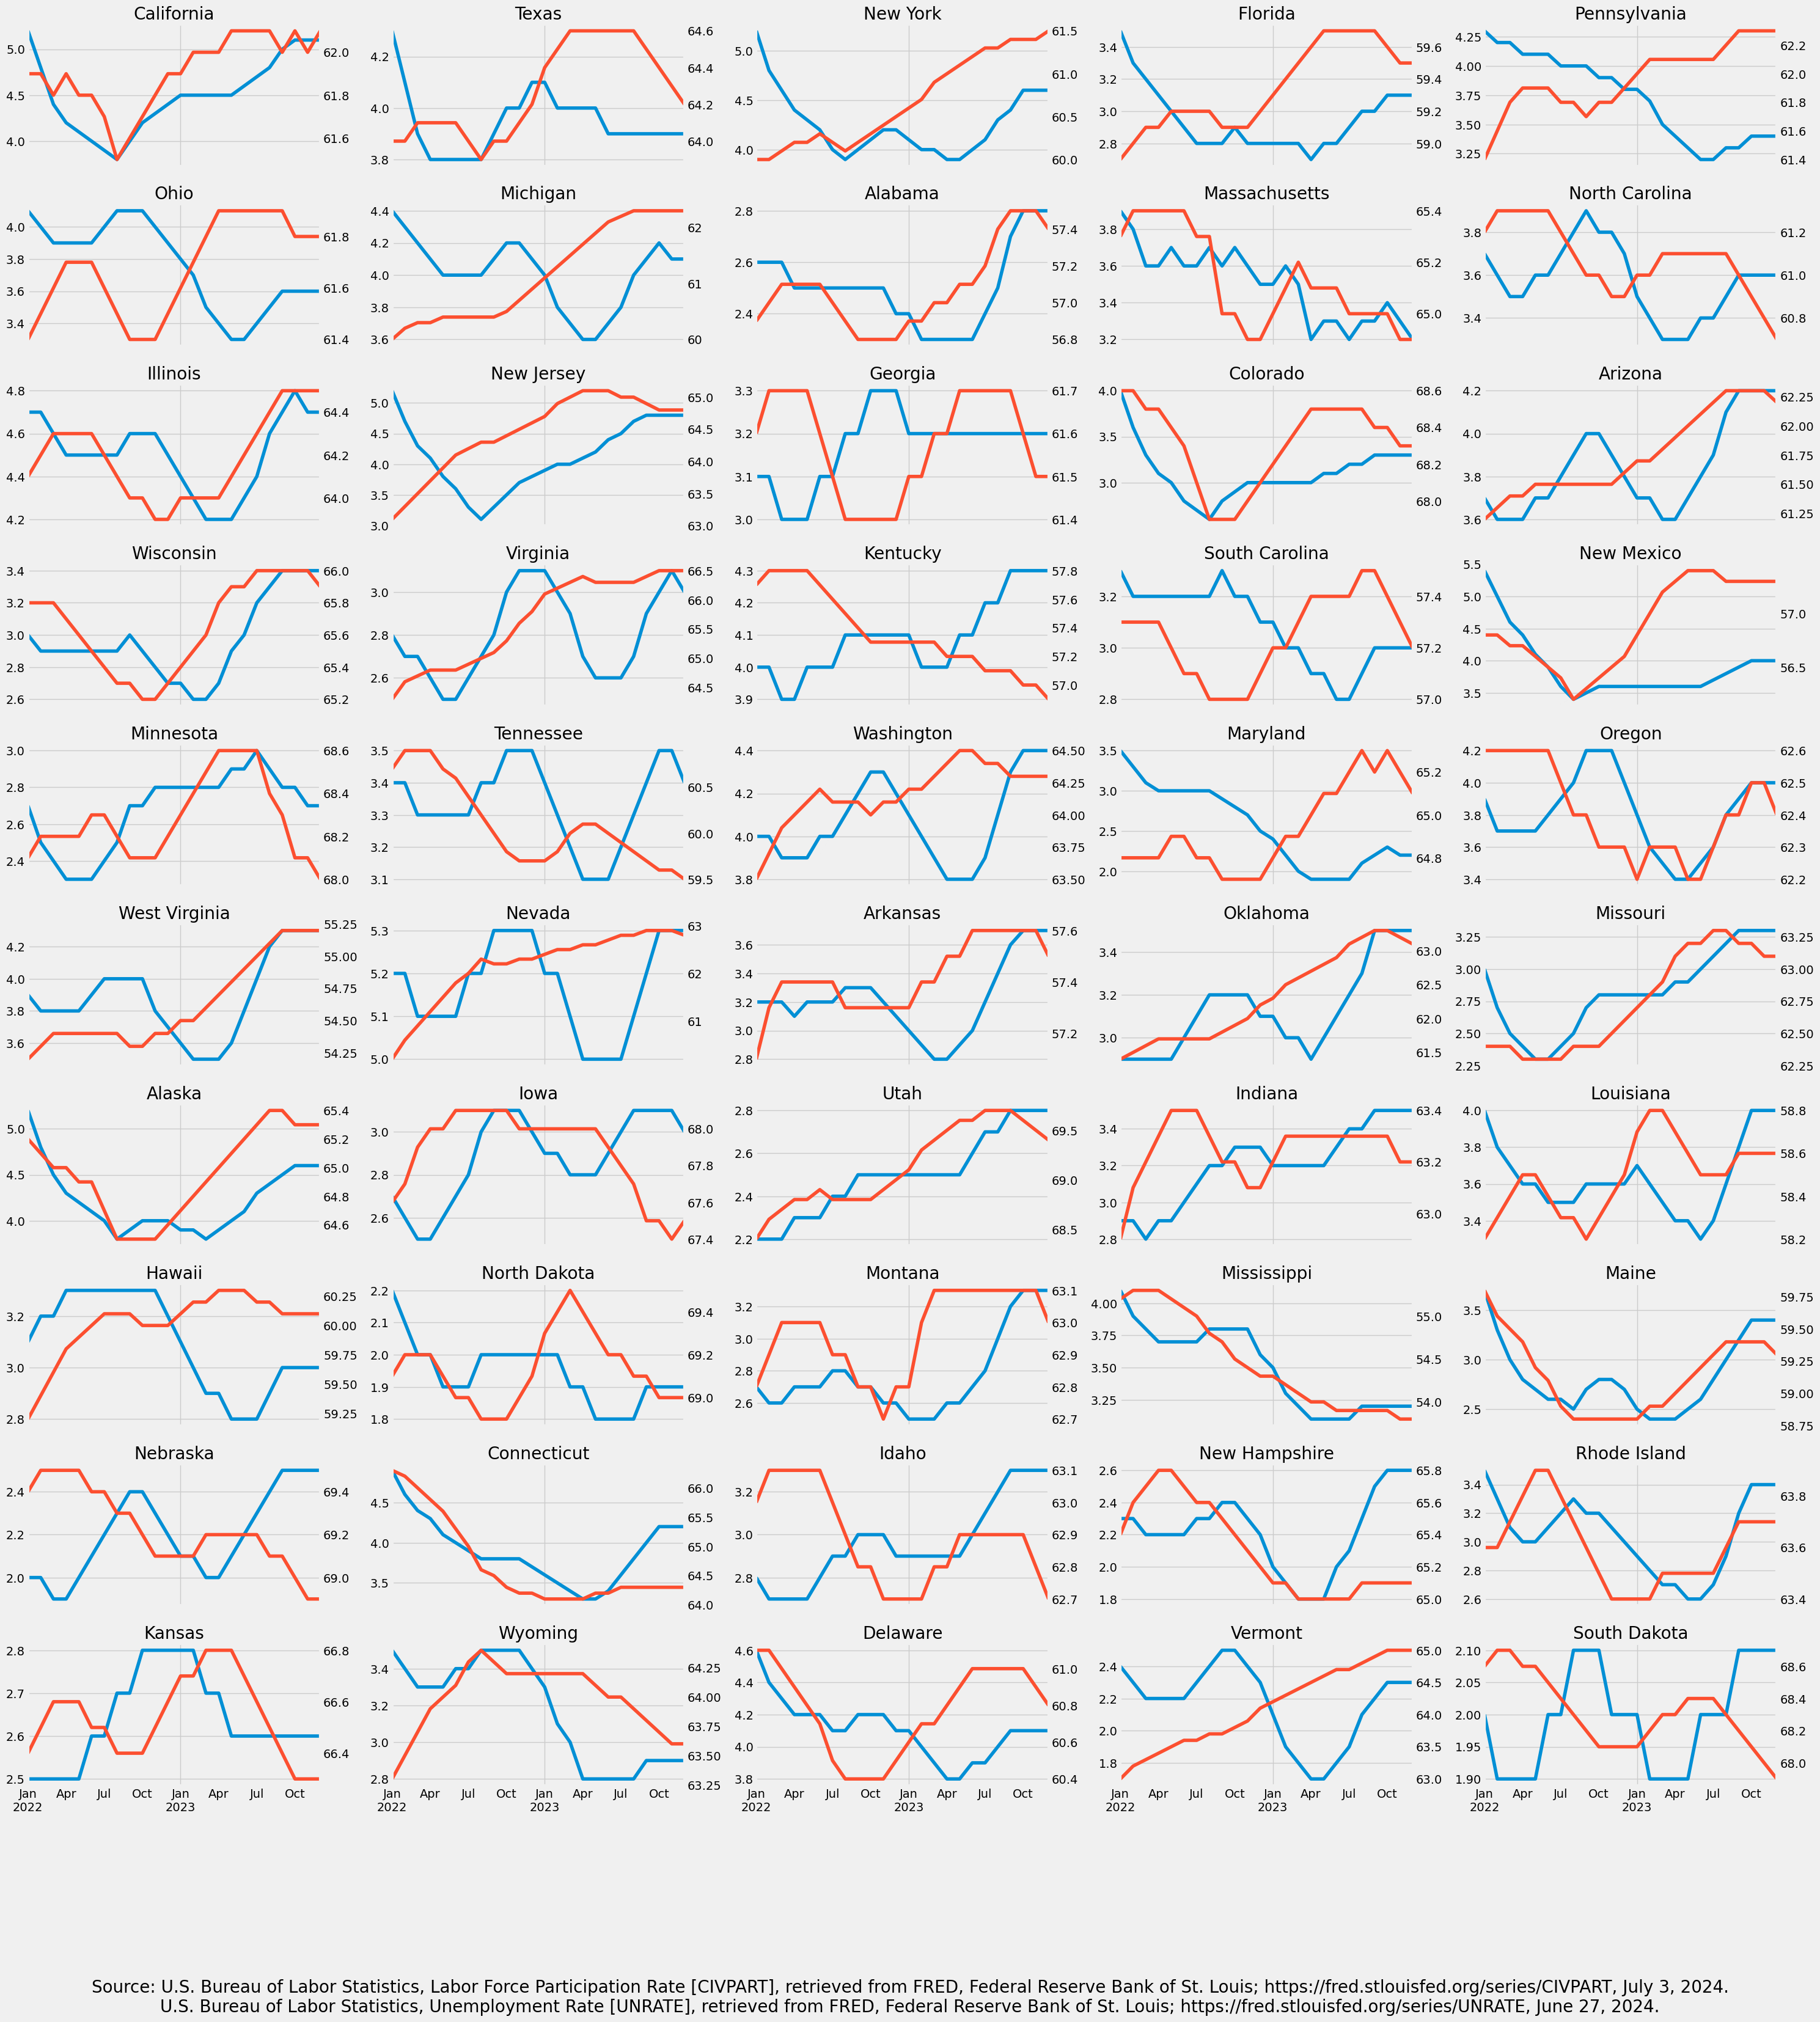

In [152]:
#Shows participation and Unemployment data for each state.
fig, axs = plt.subplots(10, 5, figsize=(30, 30), sharex=True)
axs = axs.flatten()



i = 0
for state in uemp_states.columns:
    if state in ["District Of Columbia","Puerto Rico"]:
        continue
    ax2 = axs[i].twinx()
    uemp_states.query('index >= 2022 and index < 2024')[state] \
        .plot(ax=axs[i], label='Unemployment')
    part_states.query('index >= 2022 and index < 2024')[state] \
        .plot(ax=ax2, label='Participation', color=color_pal[1])
    ax2.grid(False)
    axs[i].set_title(state)
    i += 1
plt.tight_layout()

citation_text = (
    'Source: U.S. Bureau of Labor Statistics, Labor Force Participation Rate [CIVPART], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/CIVPART, July 3, 2024.\n'
    'U.S. Bureau of Labor Statistics, Unemployment Rate [UNRATE], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/UNRATE, June 27, 2024.'
)

fig.text(0.5, -0.1, citation_text, ha='center', fontsize=20, wrap=True)

plt.show()

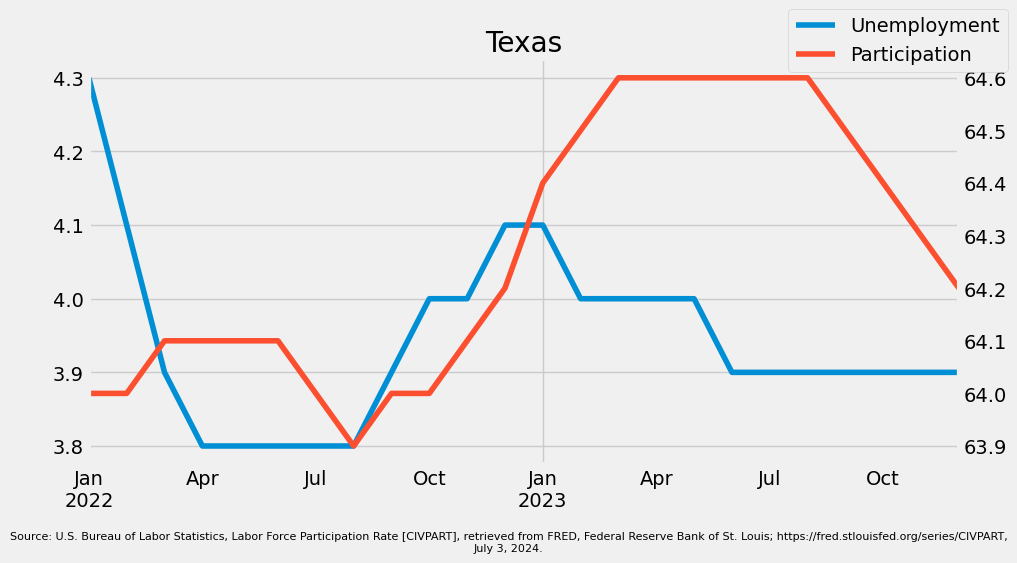

In [139]:
#Shows chart
state = 'Texas'
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
ax2 = ax.twinx()

uemp_states2 = uemp_states.asfreq('MS')

# Plot the unemployment data
l1 = uemp_states2.query('index >= 2022 and index < 2024')[state].plot(ax=ax, label='Unemployment')

# Plot the participation data
l2 = part_states.dropna().query('index >= 2022 and index < 2024')[state].plot(ax=ax2, label='Participation', color=color_pal[1])
ax2.grid(False)
ax.set_title(state)
fig.legend(labels=['Unemployment', 'Participation'])

fig.text(0.5, -0.1,  'Source: U.S. Bureau of Labor Statistics, Labor Force Participation Rate [CIVPART], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/CIVPART, July 3, 2024.', 
         ha='center', fontsize=8, wrap=True)
plt.show()

The Labor Force Participation Rate is defined as “the number of people in the labor force as a percentage of the civilian noninstitutional population, the participation rate is the percentage of the population that is either working or actively looking for work.

The Labor Force "Participation Rate" is published by the BLS. It is provided on a monthly basis, so this data is used in part by macroeconomists as an initial economic indicator of current labor market trends. The labor force participation rate helps government agencies, financial markets, and researchers gauge the overall health of the economy.

Note that long-run changes in labor force participation may reflect secular economic trends that are unrelated to the overall health of the economy. 
For instance, demographic changes such as the aging of population can lead to a secular increase of exits from the labor force, shrinking the labor force and decreasing the labor force participation rate.

### The End. Now this is only the beginning for what can be done with the FRED api.